In [25]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets
plt.rcParams['figure.figsize'] = (16,10)

rng = np.random.default_rng(0)

from utils import KalmanFilter

## Dynamical system: Lorenz attractor

In [2]:
# Dynamical system: Lorenz attractor

# Model parameters (Assumed by Lorenz)
rho = 28
sigma = 10
beta = 8/3

def f(t, y):
    return np.array([
        sigma * (y[1] - y[0]),
        y[0] * (rho - y[2]),
        y[0] * y[1] - beta * y[2]
    ])

# Initial condition based on starting at [1,1,1] and integrating to t=30
y0 = np.array([-10.04569726, -13.73820132,  25.22352555])

t = np.arange(0, 10, 0.01)

N = len(t)
dt = 0.01

sol = solve_ivp(f, t_span=(0,10), y0=y0, t_eval=t)
y = sol.y.transpose()     # Take transpose so time axis is 0
y

array([[-10.04569726, -13.73820132,  25.22352555],
       [-10.40962815, -13.98505297,  25.95971089],
       [-10.75897423, -14.15965167,  26.74738952],
       ...,
       [ 10.16844532,  10.82255622,  29.49167423],
       [ 10.22236738,  10.65492295,  29.79633433],
       [ 10.25379643,  10.4563926 ,  30.07938321]])

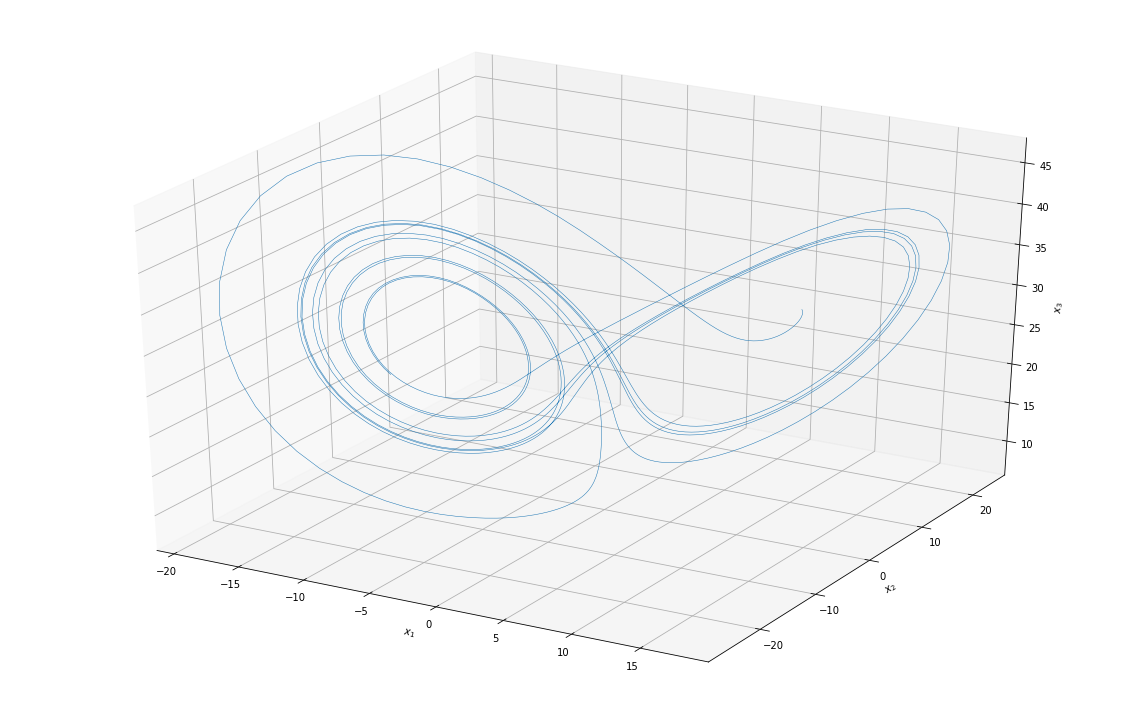

In [3]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(y[:, 0], y[:, 1], y[:, 2] ,lw=0.5)
ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$', zlabel=r'$x_3$');
fig.tight_layout()

## Compute accelerations of dynamical system
To compute our covariance matrix Q, we will need estimates for the standard deviations in accelerations in x, y, and z

In [19]:
accels = np.zeros((N,3))

for i in range(1, N-1):
    for j in range(3):
        accels[i,j] = (y[i+1, j] - 2*y[i,j] + y[i-1, j])/dt**2

accels = accels[1:-1, :]
accel_stds = accels.std(axis=0)
accel_stds

array([ 558.43662773, 1130.33280513, 1195.61251923])

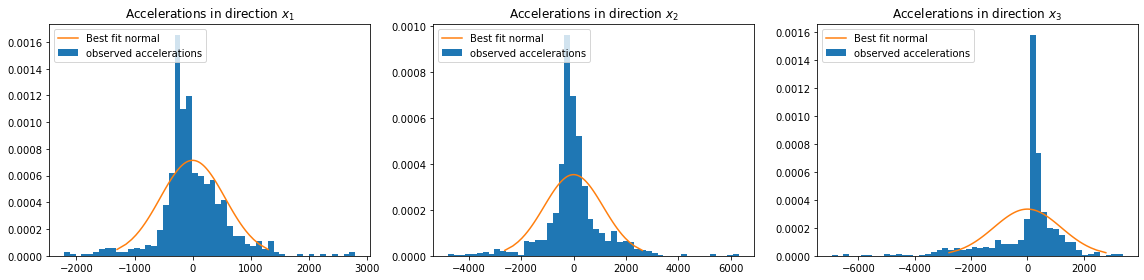

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))
for i in range(3):
    axes[i].hist(accels[:,i], bins=50, density=True, label='observed accelerations')

    ppf = norm.ppf(q=np.arange(0.01, 1, 0.01), scale=accel_stds[i])
    pdf = norm.pdf(ppf, scale=accel_stds[i])
    axes[i].plot(ppf, pdf, label='Best fit normal')
    axes[i].set_title(r'Accelerations in direction $x_{}$'.format(i+1))
    axes[i].legend(loc='upper left')
fig.tight_layout()

## Add noise to observed state

In [33]:
# Add noise to true y
R = np.eye(3)
noise = rng.multivariate_normal(mean=np.zeros(3), cov=R, size=N)
obs = y + noise

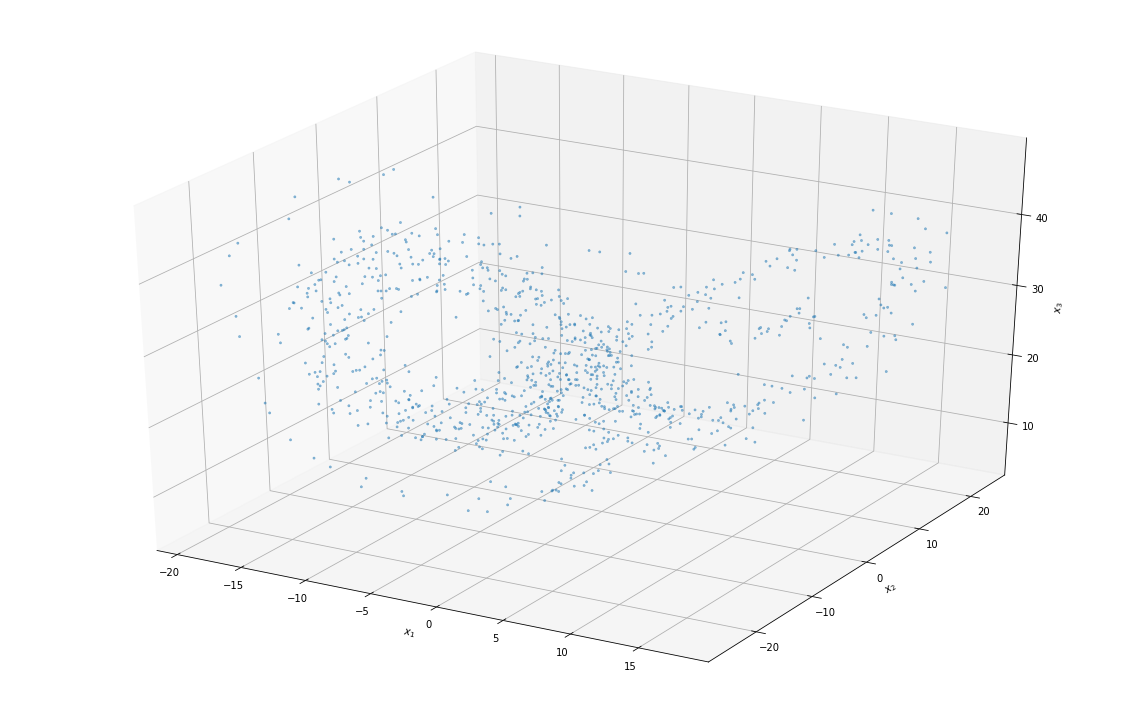

In [34]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(obs[:, 0], obs[:, 1], obs[:, 2] , lw=0.5, alpha=0.5, s=5)
ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$', zlabel=r'$x_3$');
fig.tight_layout()

## Try to predict state using kalman filter and observations

In [35]:
# Initialize Kalman filter
kf = KalmanFilter(dt, y0, R=R)
kf.set_Q(*accel_stds)

In [36]:
forecasts = []
updates = []

for i in range(1000):
    forecasts.append(kf.forecast())
    updates.append(kf.update(obs[i, :]))
    
forecasts = np.array(forecasts)
updates = np.array(updates)

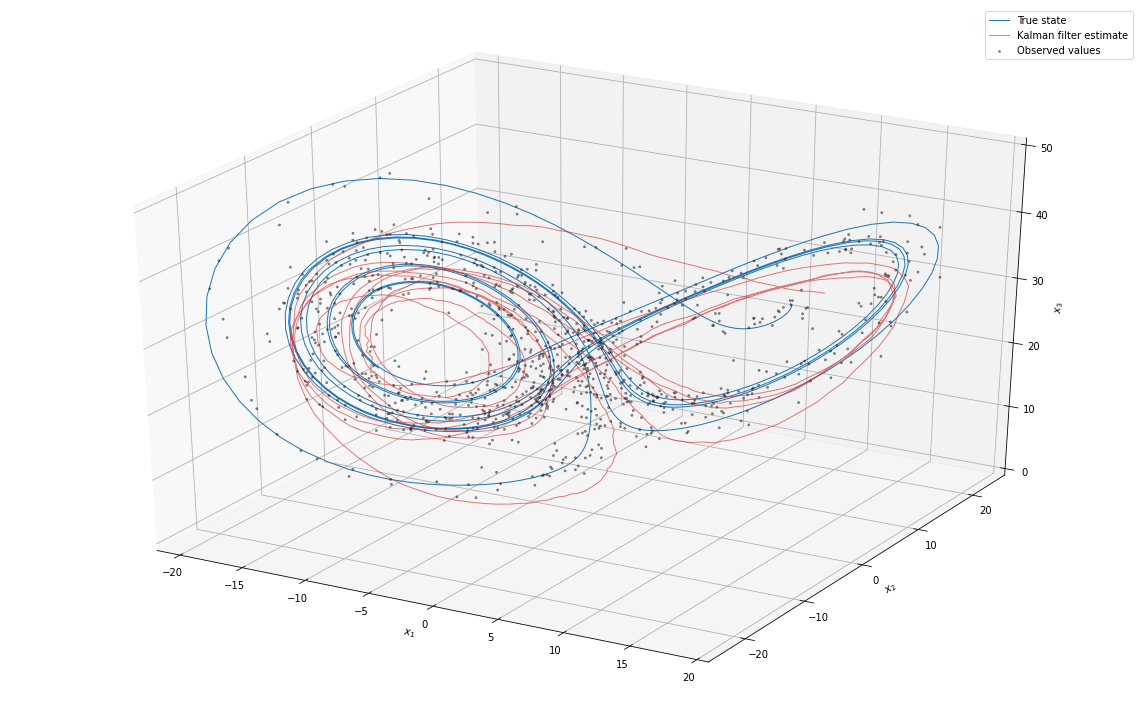

In [37]:
ax = plt.gca(projection='3d')
ax.plot(y[:, 0], y[:, 1], y[:, 2],
        lw=1, alpha=1, label='True state')
ax.scatter(obs[:, 0], obs[:, 1], obs[:, 2],
           color=(0.1,0.1,0.1), lw=0.5, alpha=0.5, s=5, label='Observed values')
ax.plot(updates[:, 0], updates[:, 1], updates[:, 2], 
        color='tab:red', lw=1, alpha=0.6, label='Kalman filter estimate')


ax.set_xlim(-21, 20)
ax.set_ylim(-25, 25)
ax.set_zlim(0, 50)
ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$', zlabel=r'$x_3$');

ax.legend()
fig = plt.gcf()
fig.tight_layout()

In [39]:
def plot(i):
    ax = plt.gca(projection='3d')
    
#     ax.plot(y[0:i, 0], y[0:i, 1], y[0:i, 2],
#             lw=1, alpha=1, label='True state')
    ax.scatter(obs[0:i, 0], obs[0:i, 1], obs[0:i, 2],
               color=(0.1,0.1,0.1), lw=0.5, alpha=0.5, s=5, label='Observed values')
    ax.plot(updates[0:i, 0], updates[0:i, 1], updates[0:i, 2], 
            color='tab:red', lw=1, alpha=0.6, label='KF estimate')
    
    
    ax.set_xlim(-21, 20)
    ax.set_ylim(-25, 25)
    ax.set_zlim(0, 50)
    ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$', zlabel=r'$x_3$');

    ax.legend()
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()

num_records = np.shape(y)[0]
ipywidgets.interact(plot, i=(0, num_records-1, 1));

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…